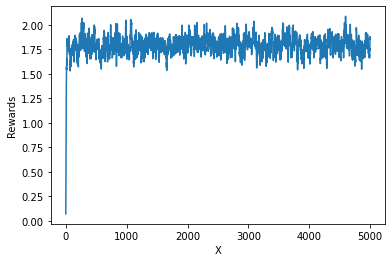

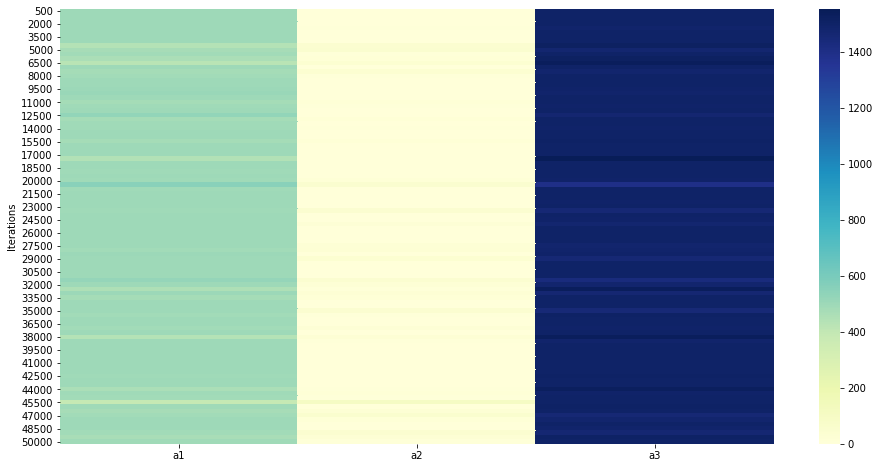

In [37]:
# Read data
import pandas as pd
filepath = '/content/new_data.csv'  
principal_Df = pd.read_csv(filepath,index_col=None)
# Change file name to category
# principal_Df.drop('Unnamed: 0', inplace=True, axis=1)

# Utility function to create arrangements. Will work till 3 actions and n grid action^box
from itertools import  permutations

def get_combinations(a, box):
  b = [a[0]] *box
  comb = []

  for i in range(1, len(a)+1):
    for j in range(len(b)):
      b[j] = a[i%len(a)]
      comb.append(tuple(b))

  for c in comb:
    c = list(c)
    if c.count(a[0]) > 1 and c.count(a[0]) < len(c):
      for i in range(c.count(a[0])-1):
        for j in range(len(c)):
          if c[j] == a[0]:
            c[j] = a[len(a)-1]
            comb.append(tuple(c))
            break
    
  comb = [list(c) for c in comb]
  return comb

def do_permutation(comb):
  arrangements = []
  for c in comb:
    p = permutations(c) 
    for j in set(list(p)): 
        arrangements.append(j)
  return set(arrangements)

# Commented out IPython magic to ensure Python compatibility.
# Imports
#---------------------------------------------------------------------------------------------------------------------#

import time
# %matplotlib inline
import numpy as np
from scipy.spatial import distance
import operator
import pickle
import matplotlib.pyplot as plt
import random
#---------------------------------------------------------------------------------------------------------------------#
# Global and helping variables
state_store=[]
BOARD_ROWS = 2
BOARD_COLS = 2
REWARDS = []
#---------------------------------------------------------------------------------------------------------------------#
# Create arragements
actions = ['a1','a2','a3']
comb = get_combinations(actions, BOARD_ROWS*BOARD_COLS )
arrangements = do_permutation(comb)

# Drop same action arrangements to maintain diversity
arrangements = list(arrangements)
#arrangements.remove( ('a1', 'a1', 'a1', 'a1') )
#arrangements.remove( ('a2', 'a2', 'a2', 'a2') )
#arrangements.remove( ('a3', 'a3', 'a3', 'a3') )

# Select Blues, Pop, Disco
temporary_df = principal_Df[ (principal_Df['Genre']=='Blues') | (principal_Df['Genre']=='Pop') | (principal_Df['Genre']=='Disco')  ]
pd.set_option('display.max_rows', temporary_df.shape[0]+1)
temporary_df = temporary_df.reset_index(drop = True)

# Get the mean of each genres
mean_blues = tuple(principal_Df[principal_Df['Genre']=='Blues'].describe().loc['mean'])
mean_disco = tuple(principal_Df[principal_Df['Genre']=='Disco'].describe().loc['mean'])
mean_pop = tuple(principal_Df[principal_Df['Genre']=='Pop'].describe().loc['mean'])

def changeSigFigto3(d):
  """
  Utility function to change float to 3 signifant figutes after decimal place
  """
  temp = []
  for value in d:
    temp.append(round(value,3))
  return tuple(temp)


# User Grid Input
PrimaryUser=[]
SecondaryUser =[]
PrimaryUser.append(changeSigFigto3(mean_pop))
SecondaryUser.append(changeSigFigto3(mean_disco))
SecondaryUser.append(changeSigFigto3(mean_pop))

def changeActiontoRow(action):
  """
  Utility function to map local actions to select random rows from respective genres
  a2r : range of data rows of a genre
  """
  a2r = {
    'a1':(0,999),
    'a2':(1000,1999),
    'a3':(2000,2999)
  }
  return changeSigFigto3(tuple(temporary_df.loc[random.randint(a2r[action][0], a2r[action][1])][1:]))

# Create board to store reward
REWARD_BOARD =  np.zeros( (len(arrangements), len(arrangements)),dtype='object')

states = arrangements.copy()
action_space = arrangements.copy()
# Converting to dictionary mappers
state_dict = {}
for i in range(len(states)):
  # key = 'S_'+ str(i)
  state_dict[i] = states[i]
action_dict = {}
for i in range(len(action_space)):
  # key = 'A_'+ str(i)
  action_dict[i] = action_space[i]

def createBoardForState(location):
  """
  Agent creates local boards and populates values by local action
  """
  index = 0
  board =  np.zeros( (BOARD_ROWS, BOARD_COLS),dtype='object')
  for row in range(BOARD_ROWS):
    for col in range(BOARD_COLS):
      board[row][col] = changeActiontoRow(location[index])
      index+=1
  return board
import math
def calculcateReward(board,user):
  """
  Agent calculates reward using euclidean distance between randomly selected k values from local boards
  """
  output_reward =0

  k = 3
  for i in range(k):
    # print([random.sample(range(int((BOARD_COLS))), 1)[0]],[random.sample(range(int((BOARD_ROWS))), 1)[0]])
    pos=board[random.sample(range(int((BOARD_COLS))), 1)[0]][random.sample(range(int((BOARD_ROWS))), 1)[0]] 
    euc_dist = distance.euclidean(pos, user)
    if euc_dist == 0:
      dst = 0
    else:
      dst = 1.0/euc_dist
      dst=math.log10(abs(dst))
    output_reward =dst+output_reward
  return output_reward

# Initliaze Q table
Q_values = {}
for i in range(len(arrangements)):
    Q_values[i] = {}
    for a in action_dict:
      Q_values[i][a] = 0  # Q value is a dict of dict

Q_values

# Randomly start off with a state
def playARound():
  state_action = []
  state_action_pair = []
  # Exploration rate
  exp_rate = 0.3
  mx_nxt_reward = 0
  action = 0
  #  Epsilon - Greedy Method
  for i in range(len(arrangements)):
    current_position = action
    if np.random.uniform(0, 1) <= exp_rate:
      # Select random action
      action = np.random.choice(list(action_dict.keys()))
    else:
      # greedy action
      for a in action_dict:
          # Check 
          # current_position = action
          nxt_reward = Q_values[current_position][a]
          # nxt_reward = calculcateReward(createBoardForState(action_dict[a]),PrimaryUser[0])
          if nxt_reward >= mx_nxt_reward:
              action = a
              mx_nxt_reward = nxt_reward
    # For current state, what is the best action. Save it
    state_action_pair.append( (current_position,action) )    
    state_action.append(action)
  return state_action, state_action_pair

def averageOfList(numOfList):
    avg = sum(numOfList) / len(numOfList)
    return avg

def maxOccur(elemlist):
  most_common_item = max(elemlist, key = elemlist.count)
  return most_common_item

def meanReward_CommActionQ(Q_table):
  q_max_keys = []
  q_max_vals = []
  for dicts in Q_table:
    max_key = max(Q_table[dicts], key=Q_table[dicts].get)
    max_value = max( Q_table[dicts].values())

    q_max_keys.append(max_key)
    q_max_vals.append(max_value)

  mean_reward = averageOfList(q_max_vals)
  most_occur_action = maxOccur(q_max_keys)
  return mean_reward, most_occur_action



noOfRounds = 50000

q_optimal_action = []
q_optimal_reward =[]
for i in range(noOfRounds):
  state_action, state_action_pair  = playARound()
  #print("Round:", i)
  #print("End of state of this round: ", action_dict[state_action[-1]])
  lr = 0.2
  decay_gamma = 0.9

  reward = calculcateReward(createBoardForState(action_dict[state_action[-1]]),PrimaryUser[0])
  # q_optimal_reward.append(reward)
  # q_optimal_action.append(state_action[-1] )
  for a in action_dict:
    Q_values[ state_action[-1] ][a] = reward
  #print("Game End Reward", reward)

  for s in reversed(state_action_pair):
      current_q_value = Q_values[s[0]][s[1]]
      reward = current_q_value + lr * (decay_gamma * reward - current_q_value)
      Q_values[s[0]][s[1]] = round(reward, 3)
  
  r,a = meanReward_CommActionQ(Q_values)
  q_optimal_reward.append(r)
  q_optimal_action.append(a)


  # max_key = max(test_state_values, key=test_state_values.get)
  # print("MDP Value: ",max_key)
  # mdp_vals.append(max_key)
  # print("Best action to take for this round: ", action_dict[max_key])
  # mdp_reward.append(test_state_values[max_key])
  # print("----------------")

def checkRewardGraph(current_reward):
    # Visualize Reward Trend over iterations.
    x=[]
    gapped_reward = []
    # Reward after 10 iterations
    for i in range(len(current_reward)):
      if i%10 == 0:
        gapped_reward.append(current_reward[i])
    
    for j in range(len(gapped_reward)):
      x.append(j)

    # import pandas library
    import pandas as pd 
    # dictionary with list object in values
    details = {
        'Rewards' : gapped_reward,
        'X' : x
    }
    # creating a Dataframe object 
    df = pd.DataFrame(details)
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Construct iris plot
    sns.lineplot(x="X", y="Rewards", data=df)

    # Show plot
    plt.show()
checkRewardGraph(q_optimal_reward)

# Check action vs iteration graph
def checkActionGraph(current_action):
    # Visualize Reward Trend over iterations.
    x=[]
    gapped_reward = []
    # Reward after 10 iterations
    for i in range(len(current_action)):
      if (i+1)%10 == 0:
        gapped_reward.append(current_action[i])
    
    for j in range(len(gapped_reward)):
      x.append(j)

    # import pandas library
    import pandas as pd 
    # dictionary with list object in values
    details = {
        'Rewards' : gapped_reward,
        'X' : x
    }
    # creating a Dataframe object 
    df = pd.DataFrame(details)
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Construct iris plot
    sns.lineplot(x="X", y="Rewards", data=df)

    # Show plot
    plt.show()
#checkActionGraph(q_optimal_action)

# Prepare heatmap
a1_count=0
a2_count=0
a3_count=0
collective_action=[]
a1=[]
a2=[]
a3=[]
iterations = []
index =1
for vals in q_optimal_action:
 
  collective_action.append(vals)
  # For every 20 iterations, collectively count number of a1 a2 a3
  if index%500==0:
    
    #print(index)
    iterations.append(index)
    for a in collective_action:
      a1_count+=action_dict[a].count('a1')
      a2_count+=action_dict[a].count('a2')
      a3_count+=action_dict[a].count('a3')
    a1.append(a1_count)
    a2.append(a2_count)
    a3.append(a3_count)
    
    a1_count=0
    a2_count=0
    a3_count=0
    collective_action=[]

  index+=1
df = pd.DataFrame({'Iterations':iterations, 'a1':a1, 'a2':a2, 'a3':a3 })
df.set_index('Iterations',inplace=True)

import seaborn as sns
fig_dims = (16, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.heatmap(data = df,ax=ax,cmap="YlGnBu")
#q_max_keys=50

#q_optimal_action



In [ ]:
q_optimal_action

In [36]:
df

,a1,a2,a3
Iterations,,,
500,500,0,1500
1000,500,0,1500
1500,500,0,1500
2000,500,0,1500
2500,522,0,1478
3000,500,0,1500
3500,506,0,1494
4000,500,0,1500
4500,500,0,1500


In [8]:
mdp_c = mdp_vals.copy()
index = 0
for keys in reversed(mdp_c):
  print('Round: ',index+1)
  if index == 20:
    break
  print(action_dict[keys])
  index+=1

NameError: ignored

In [4]:
Q_values

{0: {0: 32.219,
  1: 13.28,
  2: 21.394,
  3: 38.474,
  4: 44.721,
  5: 125.352,
  6: 16.023,
  7: 2.5656802424840275,
  8: 2.5656802424840275,
  9: 2.5656802424840275,
  10: 17.176,
  11: 2.5656802424840275,
  12: 23.943,
  13: 42.553,
  14: 11.072,
  15: 6.422,
  16: 41.327,
  17: 30.592,
  18: 41.543,
  19: 2.5656802424840275,
  20: 5.303,
  21: 30.709,
  22: 52.905,
  23: 6.092,
  24: 66.244,
  25: 2.5656802424840275,
  26: 6.405,
  27: 116.948,
  28: 44.427,
  29: 65.542,
  30: 83.979,
  31: 143.502,
  32: 26.753,
  33: 2.5656802424840275,
  34: 63.11,
  35: 46.037,
  36: 15.708,
  37: 2.521,
  38: 37.728,
  39: 71.529,
  40: 31.44,
  41: 136.841,
  42: 23.533,
  43: 80.774,
  44: 57.936,
  45: 2.5656802424840275,
  46: 43.916,
  47: 41.457,
  48: 2.5656802424840275,
  49: 8.867,
  50: 6.759,
  51: 30.71,
  52: 130.654,
  53: 193.158,
  54: 23.474,
  55: 142.062,
  56: 314.459,
  57: 31.346,
  58: 193.487,
  59: 176.457,
  60: 38.685,
  61: 2.5656802424840275,
  62: 15.154,
  63: 